##Library Import

In [1]:
!pip install ppscore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13166 sha256=c428fa3dde64db56a471abb6d3756c9244064aed461cdd1a80578d7770e43e28
  Stored in directory: /root/.cache/pip/wheels/5c/80/75/b631985b161d4a29cc0cf94b5f64b00be6297b0968ff1337ce
Successfully built ppscore


In [2]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import rcParams
from datetime import datetime, timedelta
from google.colab import files
import ppscore as pps
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
import sklearn.metrics as metrics

rcParams['figure.figsize'] = 12,6

##Data Preprocessing

In [60]:
#get list of files for concatenation
mypath = '/content/drive/MyDrive/UTS/Hass-DSI/Device Data/Device Data (Updated)/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

onlyfiles = ['ssd_36B017.csv','ssd_60C52B.csv','ssd_05500B.csv','ssd_4336AB.csv','ssd_4350B8.csv','ssd_4352F4.csv']

In [61]:
sensor='voc'
di = pd.DataFrame({'ts':[], sensor:[]})
count=0

for i in onlyfiles[:8]:
  if count==0:
    df = pd.read_csv(mypath+i)
    df=df[['ts',sensor]]
    di = pd.concat([di, df],ignore_index=True)
    di['ts'] = pd.to_datetime(di['ts'], format='%Y-%m-%d %H:%M:%S')
    di = di.resample('30T', on='ts').agg({sensor:'median'})
    di.reset_index(inplace=True)
    di.rename(columns={f"{sensor}_{i}": sensor},inplace=True)
    count+=1
  else:
    df = pd.read_csv(mypath+i)
    df=df[['ts',sensor]]
    df['ts'] = pd.to_datetime(df['ts'], format='%Y-%m-%d %H:%M:%S')
    df = df.resample('30T', on='ts').agg({sensor:'median'})
    df.reset_index(inplace=True)
    df.rename(columns={f"{sensor}_{i}": sensor},inplace=True)
    di = pd.merge(di,df,on='ts')
    di.columns = ['ts']+onlyfiles[:onlyfiles.index(i)+1]

di['Hour'] = pd.DatetimeIndex(di['ts']).hour.astype(int)
di['Weekday'] = pd.DatetimeIndex(di['ts']).weekday

In [62]:
di.head()

,ts,ssd_36B017.csv,ssd_60C52B.csv,ssd_05500B.csv,ssd_4336AB.csv,ssd_4350B8.csv,ssd_4352F4.csv,Hour,Weekday
0,2022-10-06 17:00:00,2220.380,1954.400,0.500000,598.551818,326.940909,833.33,17,3
1,2022-10-06 17:30:00,2118.580,1856.950,0.500000,589.637500,324.363000,847.03,17,3
2,2022-10-06 18:00:00,2216.710,1943.840,0.505000,568.754000,306.404167,841.71,18,3
3,2022-10-06 18:30:00,2298.465,2020.300,0.518333,583.355385,306.934545,850.52,18,3
4,2022-10-06 19:00:00,2284.740,1970.085,0.598182,583.602000,306.119167,850.79,19,3


In [63]:
di.columns = ['ts','Harris St (54)','Foyer Lifts (53)','Comp Lab 17(22)','Comp Lab 14 (9)','Comp Lab 19 (3)','Comp Lab 12 Far (1)', 'Hour', 'Weekday']

In [64]:
x,y = list(),list()

for i in range(0,len(di)):
  if 6 <= di['Hour'].iloc[i] < 18:
    x.append('A/C On')
  else:
    x.append('A/C Off')

for i in range(0,len(di)):
  if di['Weekday'].iloc[i] > 4:
    y.append('Weekend')
  else:
    y.append('Weekday')

di['AC Status'] = x
di['Day Type'] = y

In [65]:
#ds = di[di['AC Status']=='A/C On']

In [66]:
#ds = ds[ds['Day Type'] == 'Weekday']

In [67]:
ds = di[['Harris St (54)','Foyer Lifts (53)','Comp Lab 17(22)','Comp Lab 14 (9)','Comp Lab 19 (3)','Comp Lab 12 Far (1)']]

###PPS Function

In [101]:
def PPS(ds, target, cv=5):
  u,b,dict_list = list(),list(),list()

  for x in range(len(ds.columns)):
    y = ds.columns[x]
    u.append(y)
  
  keys = u

  for j in range(0,13):
    avg_values = list()
    for i in u:
      scaler = MinMaxScaler()
      variable = scaler.fit_transform(np.array(ds[i]).reshape(-1, 1))
      scaler = MinMaxScaler()
      target = scaler.fit_transform(target.reshape(-1, 1))
  
      regressor = LinearRegression()

      if j == 0:
        score = cross_val_score(regressor, variable, target, cv=cv, scoring='neg_root_mean_squared_error')
      else:
        score = cross_val_score(regressor, variable[:-j], target[j:], cv=cv, scoring='neg_root_mean_squared_error')

      average = sum(score)/len(score)
      avg_values.append(average)

    
    dictionary1 = dict(zip(keys,avg_values))

    dict_list.append(dictionary1)

  return(dict_list)

##Results

###Correlation Matrix (Pearson)

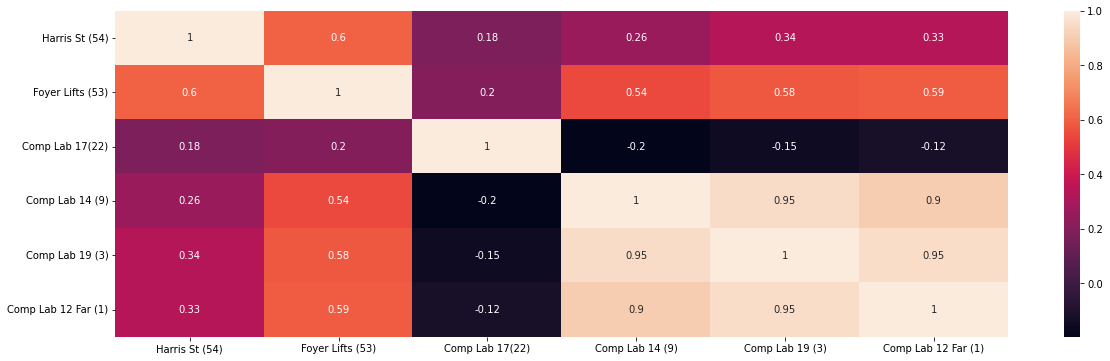

In [99]:
corrMatrix = ds.corr(method='pearson')
sns.heatmap(corrMatrix, annot=True)

In [ ]:
ds['Comp Lab 12 Far (1)'] = ds['Comp Lab 12 Far (1)'].shift(-14)
ds.dropna(inplace=True)

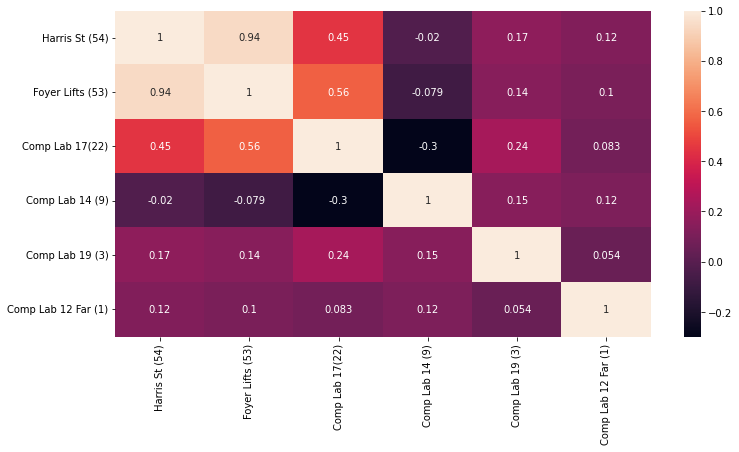

In [ ]:
corrMatrix = ds.corr(method='pearson')
sns.heatmap(corrMatrix, annot=True)

###Predictive Power Score

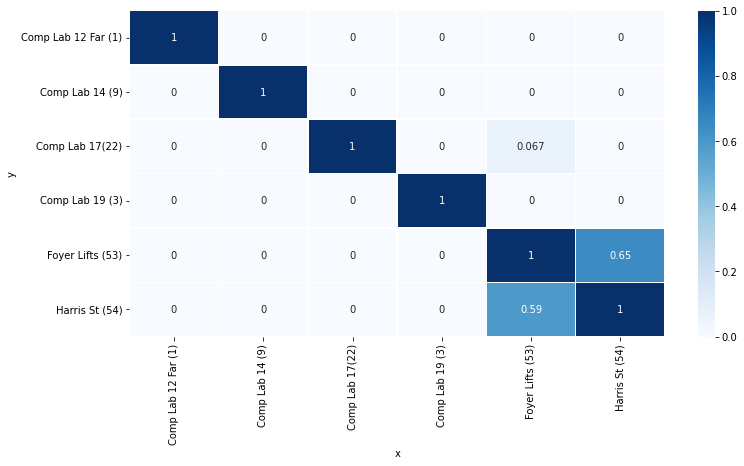

In [ ]:
matrix_df = pps.matrix(ds).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

###Lag Score

In [102]:
targetVariable = 'Comp Lab 12 Far (1)'

Data = ds.drop(columns = targetVariable)
for i in Data.columns:
  Data[i]=(Data[i]-Data[i].mean())/Data[i].std()

#Data = Data.values

#ds = df.drop(columns = targetVariable)
target = ds[targetVariable].values
target = np.nan_to_num(target)
#Data = StandardScaler().fit_transform(Data)

In [103]:
result = PPS(Data,target)
final = pd.DataFrame(result)

[Text(159.0, 0.5, 'Lag (Hour)'), Text(0.5, 33.0, 'Features')]

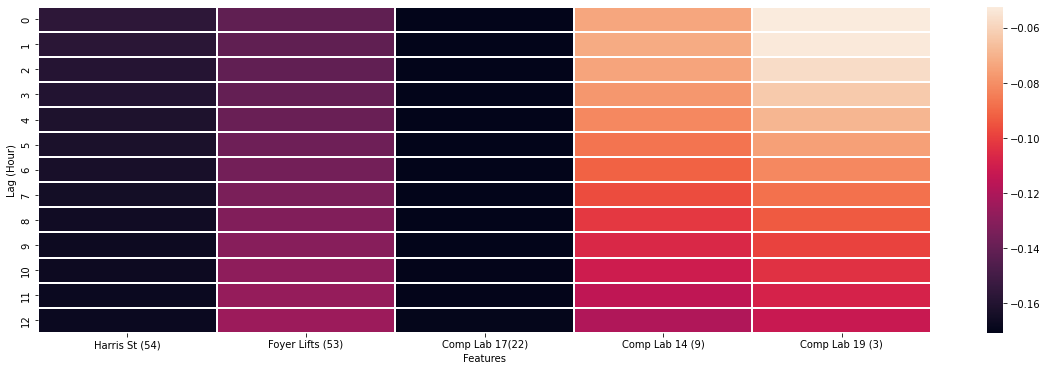

In [104]:
fig = sns.heatmap(final, linewidths=1)
fig.set(xlabel='Features', ylabel='Lag (Hour)')

###Other Analyses

In [111]:
variable1 = "Comp Lab 12 Far (1)"
variable2 = "Comp Lab 19 (3)"

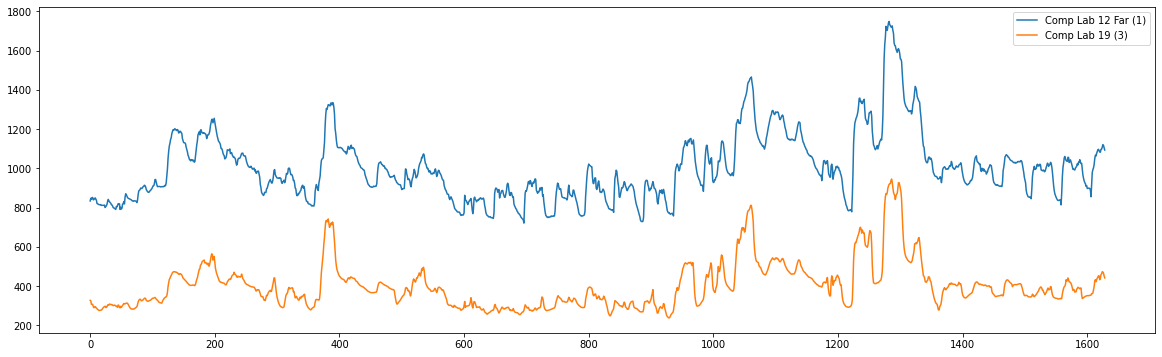

In [112]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(ds[variable1], label=variable1)
plt.plot(ds[variable2],label=variable2)
#plt.xlim([200,400])
plt.legend()

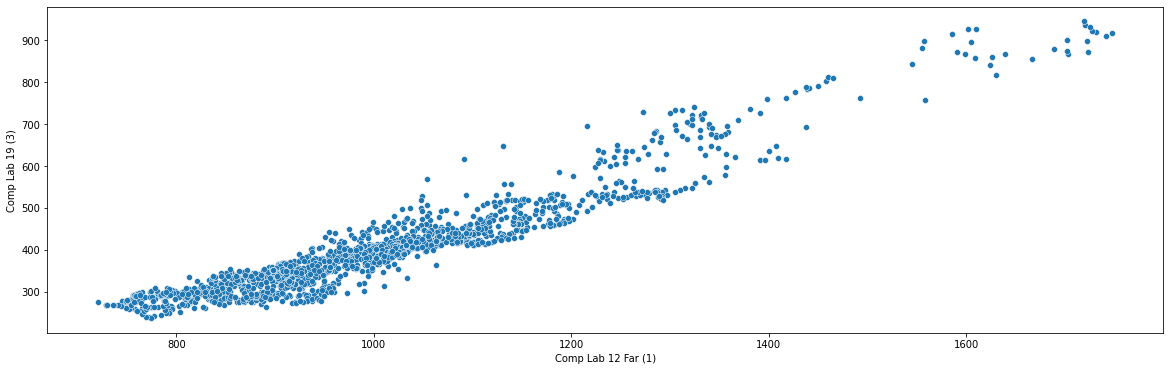

In [113]:
sns.scatterplot(data=ds, x=variable1, y=variable2)

####Time Lagged Cross Correlation

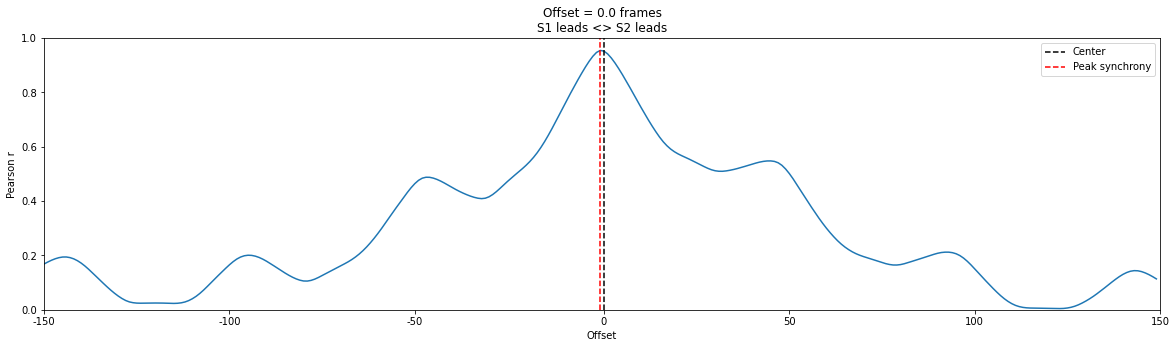

In [114]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = ds[variable1]
d2 = ds[variable2]
hours = 5
fph = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(hours*fph),int(hours*fph+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(20,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[0,1],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()